In [1]:
import pandas as pd
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
#change this image path to where the images are present in your computer
image_path = "/Users/pranavsomani/Downloads/Blastocyst_Dataset/Images/"

In [2]:
#open datasets 
gold = pd.read_csv("gold_labeled.csv")
silver = pd.read_csv("silver_labeled.csv")

In [3]:
#the following code is to transform string labels into their corresponding numerical value. 
#We use sklearn's labelencoder to be able to do so
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

#Update paths to include the full path
silver["Image"] = silver["Image"].apply(lambda x: image_path + x)
train_paths = silver["Image"].to_list()
train_labels = silver["label"].to_list()

#Encode labels as integers
train_labels = label_encoder.fit_transform(train_labels)

#One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=3)

#Repeat same process for test set
gold["Image"] = gold["Image"].apply(lambda x: image_path + x)
test_paths = gold["Image"].to_list()
test_labels = gold["label"].to_list()

#Encode labels as integers
test_labels = label_encoder.transform(test_labels)

#One-hot encode labels
test_labels = to_categorical(test_labels, num_classes=3)

Image loaded from Tensor("args_0:0", shape=(), dtype=string), shape: <unknown>
Error loading Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Image loaded from Tensor("args_0:0", shape=(), dtype=string), shape: <unknown>
Error loading Tensor("args_0:0", shape=(), dtype=string): 'images' contains no shape.
Epoch 1/10
64/64 - 18s - loss: 0.9457 - accuracy: 0.6223 - val_loss: 1.1231 - val_accuracy: 0.4167 - 18s/epoch - 281ms/step
Epoch 2/10
64/64 - 17s - loss: 0.9359 - accuracy: 0.6306 - val_loss: 1.2381 - val_accuracy: 0.4167 - 17s/epoch - 272ms/step
Epoch 3/10
64/64 - 18s - loss: 0.9296 - accuracy: 0.6306 - val_loss: 1.1788 - val_accuracy: 0.4167 - 18s/epoch - 276ms/step
Epoch 4/10
64/64 - 18s - loss: 0.9230 - accuracy: 0.6306 - val_loss: 1.2567 - val_accuracy: 0.4167 - 18s/epoch - 283ms/step
Epoch 5/10
64/64 - 18s - loss: 0.9317 - accuracy: 0.6306 - val_loss: 1.1759 - val_accuracy: 0.4167 - 18s/epoch - 279ms/step
Epoch 6/10
64/64 - 18s - loss: 0.9243 - accuracy: 

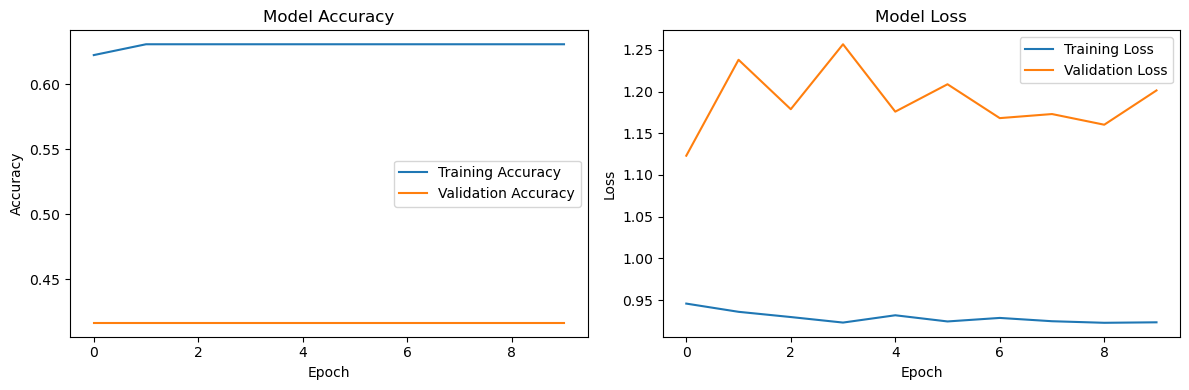

In [5]:
#This function reads in images in a manner that is usable by the CNN
def load_and_preprocess_image(path, label):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)

        print(f"Image loaded from {path}, shape: {img.shape}")
        if img.shape == ():
            raise ValueError(f"Image at {path} is not valid or could not be decoded.")
        img = tf.image.resize(img, (128, 128))
        img = img / 255.0 
        return img, label
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return tf.zeros((128, 128, 3)), label 

#Augment the images in multiple ways (flipping, changing saturation, contrast, brightness, etc.) to add variance in dataset and prevent overfitting
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.rot90(image) 
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0 
    return image

#Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(lambda path, label: load_and_preprocess_image(path, label))
train_ds = train_ds.map(lambda img, label: (augment_image(img), label))
train_ds = train_ds.batch(32).shuffle(1000)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess_image).batch(32)

#Simple CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(3, activation='softmax') 
])

#fit model with early stopping
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=test_ds, 
    verbose=2 
)

# Visualize training
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()